In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import os
import PIL
# pil is an image library in python

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, cache_dir='./Datasets/', untar=True)

228813984/228813984 [==============================] - 128s 1us/step


In [8]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('Datasets/datasets/flower_photos')

In [10]:
len(list(data_dir.glob('*/*.jpg')))

3670

In [11]:
roses = list(data_dir.glob('roses/*.jpg'))
roses[:5]

[WindowsPath('Datasets/datasets/flower_photos/roses/10090824183_d02c613f10_m.jpg'),
 WindowsPath('Datasets/datasets/flower_photos/roses/102501987_3cdb8e5394_n.jpg'),
 WindowsPath('Datasets/datasets/flower_photos/roses/10503217854_e66a804309.jpg'),
 WindowsPath('Datasets/datasets/flower_photos/roses/10894627425_ec76bbc757_n.jpg'),
 WindowsPath('Datasets/datasets/flower_photos/roses/110472418_87b6a3aa98_m.jpg')]

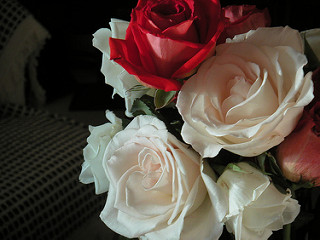

In [12]:
PIL.Image.open(str(roses[1]))

In [16]:
flowers_image_mapping = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}


flowers_label_mapping = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4
}

In [22]:
img = cv2.imread(str(flowers_image_mapping['roses'][0]))
img.shape

# (240, 179, 3) ---> (X,Y, (rgb))

(240, 179, 3)

In [23]:
cv2.resize(img, (180, 180)).shape

(180, 180, 3)

In [26]:
X, y = [], []

for flower_name, images in flowers_image_mapping.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, (180, 180))
        X.append(resized_img)
        y.append(flowers_label_mapping[flower_name])

In [28]:
X = np.array(X)
y = np.array(y)

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

In [30]:
len(X_train)

2752

In [32]:
len(X_test)

918

In [36]:
X_train_scaled = X_train/255
X_test_scaled = X_test/255

In [37]:
model = Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),

    # dense layers
    layers.Dense(128, activation='relu'),
    layers.Dense(5),
])

model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
)

model.fit(X_train_scaled, y_train, epochs=10)

Epoch 1/10
86/86 [==============================] - 59s 635ms/step - loss: 1.3234 - accuracy: 0.4477
Epoch 2/10
86/86 [==============================] - 54s 625ms/step - loss: 0.9865 - accuracy: 0.6156
Epoch 3/10
86/86 [==============================] - 53s 621ms/step - loss: 0.8354 - accuracy: 0.6791
Epoch 4/10
86/86 [==============================] - 54s 631ms/step - loss: 0.6550 - accuracy: 0.7555
Epoch 5/10
86/86 [==============================] - 56s 652ms/step - loss: 0.4097 - accuracy: 0.8594
Epoch 6/10
86/86 [==============================] - 54s 634ms/step - loss: 0.2375 - accuracy: 0.9219
Epoch 7/10
86/86 [==============================] - 55s 636ms/step - loss: 0.1531 - accuracy: 0.9520
Epoch 8/10
86/86 [==============================] - 54s 631ms/step - loss: 0.1002 - accuracy: 0.9709
Epoch 9/10
86/86 [==============================] - 55s 642ms/step - loss: 0.0601 - accuracy: 0.9847
Epoch 10/10
86/86 [==============================] - 55s 636ms/step - loss: 0.0354 - accura

In [38]:
model.evaluate(X_test_scaled, y_test)

29/29 [==============================] - 6s 160ms/step - loss: 2.1006 - accuracy: 0.6307


[2.1005890369415283, 0.6307189464569092]

In [39]:
predictions = model.predict(X_test_scaled)
predictions

29/29 [==============================] - 5s 147ms/step


array([[  1.9407129 ,  22.59983   ,  -0.43325812,  -8.00459   ,
         -3.3661962 ],
       [  8.15533   ,   0.8112071 , -12.757038  ,  -9.883643  ,
          1.1783043 ],
       [ -2.5319076 ,   2.1029694 ,  10.779607  ,  -0.8710467 ,
         -1.4462785 ],
       ...,
       [  0.17244333,  -2.7237325 ,  -1.2771968 ,   5.994793  ,
          5.9948444 ],
       [  1.2060153 ,   4.03515   ,  -2.5258617 ,  -2.361308  ,
          2.7478783 ],
       [  0.69461083,  -8.964501  ,   2.8907683 ,   9.43705   ,
          3.2221987 ]], dtype=float32)

here the model trains with a score of 99% accuracy, however on test dataset, it turns out that the model performs poorly with 65% accuracy.
This is called overfitting where model performs well on training data but performs badly on test data.

So now we perform data augmentation to overcome overfitting

In [50]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.3),
])

In [51]:
model = Sequential([
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    # dense layers
    layers.Dense(128, activation='relu'),
    layers.Dense(5),
])

model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
)

model.fit(X_train_scaled, y_train, epochs=10)

Epoch 1/10
86/86 [==============================] - 68s 716ms/step - loss: 1.3774 - accuracy: 0.4084
Epoch 2/10
86/86 [==============================] - 63s 738ms/step - loss: 1.1365 - accuracy: 0.5342
Epoch 3/10
86/86 [==============================] - 62s 723ms/step - loss: 1.0226 - accuracy: 0.5905
Epoch 4/10
86/86 [==============================] - 64s 747ms/step - loss: 0.9546 - accuracy: 0.6152
Epoch 5/10
86/86 [==============================] - 65s 759ms/step - loss: 0.9067 - accuracy: 0.6479
Epoch 6/10
86/86 [==============================] - 71s 821ms/step - loss: 0.8616 - accuracy: 0.6541
Epoch 7/10
86/86 [==============================] - 66s 771ms/step - loss: 0.8178 - accuracy: 0.6831
Epoch 8/10
86/86 [==============================] - 63s 732ms/step - loss: 0.7763 - accuracy: 0.7013
Epoch 9/10
86/86 [==============================] - 63s 727ms/step - loss: 0.7439 - accuracy: 0.7202
Epoch 10/10
86/86 [==============================] - 62s 726ms/step - loss: 0.7243 - accura

In [52]:
model.evaluate(X_test_scaled, y_test)

29/29 [==============================] - 5s 167ms/step - loss: 0.8418 - accuracy: 0.6852


[0.8418332934379578, 0.6851851940155029]

In [53]:
model.predict(X_test_scaled)

29/29 [==============================] - 5s 166ms/step


array([[ 1.457499  ,  5.545925  , -2.083177  , -2.064933  ,  2.4392426 ],
       [ 3.0467668 ,  0.02197814, -2.3218992 , -2.2821288 ,  1.2737687 ],
       [ 0.02125941,  1.4875526 ,  4.587941  , -4.176841  , -1.4802924 ],
       ...,
       [ 1.0921681 , -1.4271353 , -0.5089896 ,  4.0913124 ,  1.7960771 ],
       [ 2.582858  , -0.5382441 , -0.06549005, -3.390318  ,  1.2540481 ],
       [ 1.647005  , -3.7113934 ,  2.2058954 ,  2.1767836 ,  2.2592072 ]],
      dtype=float32)